In [1]:
from rdkit import Chem
from rdkit.Chem import Draw, rdFMCS, AllChem, rdMolAlign
from IPython.display import display, Image
import os
import matplotlib.pyplot as plt
from Bio import PDB

In [2]:
def extract_neuraminidase_pharmacophore(pdb_file):
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure('molecule', pdb_file)

    neuraminidase_pharmacophore = {
        'HBD': [],
        'HBA': [],
        'Aro': [],
        'PosCharge': [],
        'NegCharge': [],
     
    }

    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    if atom.element == 'N' and atom.get_id()[0] == ' ':
                        neuraminidase_pharmacophore['HBD'].append(atom.get_vector())
                    elif atom.element in ['O', 'S'] and atom.get_id()[0] == ' ':
                        neuraminidase_pharmacophore['HBA'].append(atom.get_vector())
                    elif atom.element == 'C' and atom.parent.id == ' ':
                        neuraminidase_pharmacophore['Aro'].append(atom.get_vector())
                    elif atom.element == 'N' and atom.parent.resname == 'ARG':
                        neuraminidase_pharmacophore['PosCharge'].append(atom.get_vector())
                    elif atom.element == 'O' and atom.parent.resname == 'ASP':
                        neuraminidase_pharmacophore['NegCharge'].append(atom.get_vector())
            
    return neuraminidase_pharmacophore

In [3]:
# Define PDB file paths
pdb_file1 = 'Zanamivir.pdb'
pdb_file2 = 'Oseltamivir.pdb'
pdb_file3 = 'Peramivir.pdb'

In [4]:
# Extract pharmacophore features from each PDB file
neuraminidase_pharmacophore1 = extract_neuraminidase_pharmacophore(pdb_file1)
neuraminidase_pharmacophore2 = extract_neuraminidase_pharmacophore(pdb_file2)
neuraminidase_pharmacophore3 = extract_neuraminidase_pharmacophore(pdb_file3)

In [5]:
# Perform a common substructure search using RDKit
mols = [Chem.MolFromPDBFile(pdb_file1), Chem.MolFromPDBFile(pdb_file2), Chem.MolFromPDBFile(pdb_file3)]
res = rdFMCS.FindMCS(mols)
common_substructure = Chem.MolFromSmarts(res.smartsString)

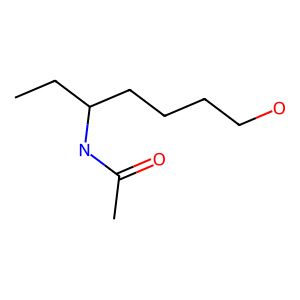

In [6]:
# Visualize the common substructure
img = Draw.MolToImage(common_substructure, size=(300, 300))
display(img)

In [7]:
# Visualize the neuraminidase pharmacophore features
def visualize_neuraminidase_pharmacophore(neuraminidase_pharmacophore, mol_file):
    mol = Chem.MolFromPDBFile(mol_file)
    AllChem.Compute2DCoords(mol)

    # Create a copy of the molecule for visualization
    mol_copy = Chem.Mol(mol)
    # Add pharmacophore features as colored dummy atoms
    for feature_type, feature_points in neuraminidase_pharmacophore.items():
        for point in feature_points:
            atom = Chem.AtomFromSmiles('*')  # Dummy atom
            atom.SetProp('PharmacophoreType', feature_type)
            atom.SetProp('Coords', ','.join(map(str, point)))
            mol_copy.AddAtom(atom)

    # Visualize the molecule with pharmacophore features
    img = Draw.MolToImage(mol_copy, size=(300, 300))
    display(img)

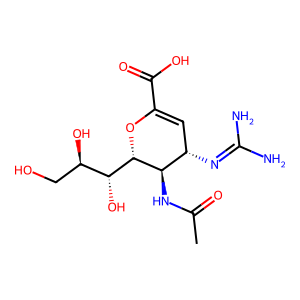

In [8]:
visualize_neuraminidase_pharmacophore(neuraminidase_pharmacophore1, pdb_file1)

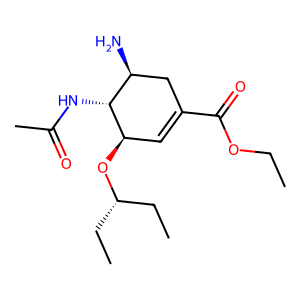

In [9]:
visualize_neuraminidase_pharmacophore(neuraminidase_pharmacophore2, pdb_file2)

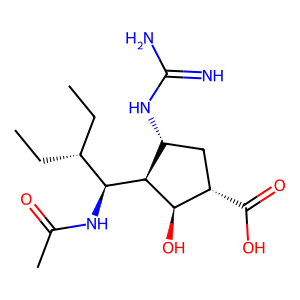

In [10]:
visualize_neuraminidase_pharmacophore(neuraminidase_pharmacophore3, pdb_file3)

In [11]:
def calculate_rmsd(custom_pdb_file, reference_pharmacophores):
    # Extract pharmacophore features from the custom PDB file
    custom_pharmacophore = extract_neuraminidase_pharmacophore(custom_pdb_file)

    # Convert pharmacophores to RDKit molecules
    custom_mol = Chem.MolFromPDBFile(custom_pdb_file)
    reference_mols = [Chem.MolFromPDBFile(pdb_file) for pdb_file in reference_pharmacophores]

    # Perform common substructure search among the custom molecule and reference molecules
    res = rdFMCS.FindMCS([custom_mol] + reference_mols)
    common_substructure = Chem.MolFromSmarts(res.smartsString)

    # Align molecules based on the common substructure
    rmsd_values = []
    for ref_mol in reference_mols:
        ref_match = ref_mol.GetSubstructMatch(common_substructure)
        custom_match = custom_mol.GetSubstructMatch(common_substructure)
        rmsd = rdMolAlign.AlignMol(custom_mol, ref_mol, atomMap=list(zip(custom_match, ref_match)))
        rmsd_values.append(rmsd)

    return rmsd_values

In [12]:
# Example usage
custom_pdb_file = 'output.pdb'
reference_pharmacophores = [pdb_file1, pdb_file2, pdb_file3]

In [13]:
rmsd_values = calculate_rmsd(custom_pdb_file, reference_pharmacophores)

# Print RMSD values
for i, rmsd in enumerate(rmsd_values):
    print(f'RMSD between custom and reference pharmacophore {i+1}: {rmsd:.4f}')


RMSD between custom and reference pharmacophore 1: 1.8748
RMSD between custom and reference pharmacophore 2: 0.6488
RMSD between custom and reference pharmacophore 3: 1.5451
